In [1]:

import numpy as np
from numpy import matlib
import matplotlib.pyplot as plt
import scipy
import matplotlib
import tqdm
from scipy import integrate, fft, sparse
import pandas as pd
import seaborn as sns
import random
import anndata
import os
from sklearn.metrics import confusion_matrix
import loompy as lp

import anndata
import scanpy as sc

from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics.pairwise import cosine_similarity


In [2]:
import sys
import importlib
sys.path.insert(0, '/home/tchari/monod/src/')

In [3]:
import monod
#importlib.reload(monod)
from monod import preprocess, extract_data, cme_toolbox, inference, analysis, mminference

In [4]:
import warnings
warnings.filterwarnings('ignore', category=PendingDeprecationWarning) 

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [69]:
#From https://github.com/pachterlab/CGCCP_2023/blob/main/Code/Preprint/Preprocess_Data.ipynb, B08 sample

#Already selected for hvgs
ds = lp.connect('/home/tchari/counts/allen_bivi/loom/B08_processed_hv.loom')
ds

,,,,,,,,Cell Type,L5 IT,L2/3 IT,L5 IT,L2/3 IT,L6 CT,L5 IT,L5 IT,L6 IT,L2/3 IT,L2/3 IT,...
,,,,,,,,barcode,AAACCCAAGTGAACAT,AAACCCAAGTTGAATG,AAACCCACACGATAGG,AAACCCACAGAGGGTT,AAACCCAGTACTAAGA,AAACCCAGTACTGGGA,AAACCCAGTCGTATGT,AAACCCATCATACAGC,AAACCCATCATAGGCT,AAACGAAAGAAGCGAA,...
,,,,,,,,class_label,Glutamatergic,Glutamatergic,Glutamatergic,Glutamatergic,Glutamatergic,Glutamatergic,Glutamatergic,Glutamatergic,Glutamatergic,Glutamatergic,...
,,,,,,,,cluster_id,42,40,42,40,60,42,42,45,40,40,...
,,,,,,,,cluster_label,L5 IT Tcap_2,L2/3 IT,L5 IT Tcap_2,L2/3 IT,L6 CT Cpa6_1,L5 IT Tcap_2,L5 IT Tcap_2,L6 IT Sulf1_1,L2/3 IT,L2/3 IT,...
,,,,,,,,obs_names,1,2,5,6,7,8,9,10,11,13,...
,,,,,,,,subclass_label,L5 IT,L2/3 IT,L5 IT,L2/3 IT,L6 CT,L5 IT,L5 IT,L6 IT,L2/3 IT,L2/3 IT,...
Spliced,dispersions,dispersions_norm,gene_id,gene_name,highly_variable,means,var_names,,,,,,,,,,,,...
0,0.9820677777884145,2.030395746231079,ENSMUSG00000063558.4,Aox1,1,0.004415014219732092,80-u,,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...
0,1.8735677492433074,4.441442012786865,ENSMUSG00000010175.13,Prox1,1,0.3310880533908806,124-u,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...
0,1.0491018338864364,2.1265413761138916,ENSMUSG00000015355.13,Cd48,1,0.002022428262812959,135-u,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...


In [31]:
meta = pd.DataFrame()
meta['cell_type'] = ds.ca['Cell Type']
meta['cell_barcode'] = ds.ca['barcode']
meta['cluster_id'] = ds.ca['cluster_id']
meta['class_label'] = ds.ca['class_label']

uniqs = np.unique(meta['cell_type'])
cell_type_dict = dict(zip(uniqs,range(len(uniqs))))
meta['cell_type_id'] = [cell_type_dict[i] for i in meta['cell_type']]

print(meta.head())
#Just in case
counts = ds.layers['counts'][:,:] #U,S x cells for 2000 hvgs, Raw counts

  cell_type      cell_barcode  cluster_id    class_label  cell_type_id
0     L5 IT  AAACCCAAGTGAACAT          42  Glutamatergic             4
1   L2/3 IT  AAACCCAAGTTGAATG          40  Glutamatergic             2
2     L5 IT  AAACCCACACGATAGG          42  Glutamatergic             4
3   L2/3 IT  AAACCCACAGAGGGTT          40  Glutamatergic             2
4     L6 CT  AAACCCAGTACTAAGA          60  Glutamatergic             6


In [37]:
#Save with standard names
all_counts = counts.T
allS = all_counts[:,2000:]
allU = all_counts[:,0:2000]
retAdata = anndata.AnnData(
			X=allS,
			layers={
				'spliced': allS,
				'unspliced': allU
			},
			obs=pd.DataFrame({'barcode': ds.ca['barcode']},index=ds.ca['barcode']),
			var=pd.DataFrame({'gene_name': ds.ra['gene_name'][0:2000]},index=ds.ra['gene_name'][0:2000])
		)

retAdata.write_loom('/home/tchari/counts/allen_bivi/loom/correct_B08_processed_hv.loom')

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [70]:
ds.close()

In [50]:
meta['cell_type'] = [i.replace(' ','_') for i in meta['cell_type']]
meta['cell_type'] = [i.replace('/','-') for i in meta['cell_type']]

In [51]:
meta['cell_type'].value_counts()

L5_IT         2395
L6_CT         1333
L2-3_IT        823
L6_IT          489
Sst            271
L5-6_NP        251
Vip            233
Lamp5          192
Pvalb          114
Oligo           82
L6b             66
Astro           49
Sncg            45
Endo            21
Macrophage      17
OPC             17
L5_ET            9
VLMC             7
L6_IT_Car3       3
SMC              1
Name: cell_type, dtype: int64

## **Initialize/Filter Data for Inference**

In [131]:
chosen = ['L6_CT','L2-3_IT','L6_IT'] #'L6_CT','L2-3_IT','L6_IT', 'L5_IT','L2-3_IT','L6_IT'
individs = [[i] for i in chosen]

In [132]:
dataset_meta = ['correct_B08_processed_hv']
print('dataset_meta: ', dataset_meta)
print()


ks = [1,2,3,4,5]
#DUSP9_MAPK1__DUSP9_MAPK1 may have 'multiple transcriptional states'
subcluster_names = [chosen]*5+individs

sub_names_only = ['_'.join(n) for n in subcluster_names]
for i in range(5):
    sub_names_only[i] = sub_names_only[i]+'_k'+str(ks[i])
    
cluster_names = []
dataset_names = ['allen_'+dataset_meta[0]+'_'+y  for y in sub_names_only]   #To save
print('dataset_names: ', dataset_names)
print('len(dataset_names): ',len(dataset_names))
print()

raw_data_locations = [dataset_meta[0] for y in sub_names_only]
transcriptome_filepath = '/home/tchari/perturbCME/notebooks/gg_200524_mouse_genome_polyA_cum_1'

spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]

loom_filepaths = ['/home/tchari/counts/allen_bivi/loom/'+x+'.loom' for x in raw_data_locations] 
print('loom_filepaths: ',loom_filepaths)

n_datasets = len(loom_filepaths)

dataset_meta:  ['correct_B08_processed_hv']

dataset_names:  ['allen_correct_B08_processed_hv_L6_CT_L2-3_IT_L6_IT_k1', 'allen_correct_B08_processed_hv_L6_CT_L2-3_IT_L6_IT_k2', 'allen_correct_B08_processed_hv_L6_CT_L2-3_IT_L6_IT_k3', 'allen_correct_B08_processed_hv_L6_CT_L2-3_IT_L6_IT_k4', 'allen_correct_B08_processed_hv_L6_CT_L2-3_IT_L6_IT_k5', 'allen_correct_B08_processed_hv_L6_CT', 'allen_correct_B08_processed_hv_L2-3_IT', 'allen_correct_B08_processed_hv_L6_IT']
len(dataset_names):  8

loom_filepaths:  ['/home/tchari/counts/allen_bivi/loom/correct_B08_processed_hv.loom', '/home/tchari/counts/allen_bivi/loom/correct_B08_processed_hv.loom', '/home/tchari/counts/allen_bivi/loom/correct_B08_processed_hv.loom', '/home/tchari/counts/allen_bivi/loom/correct_B08_processed_hv.loom', '/home/tchari/counts/allen_bivi/loom/correct_B08_processed_hv.loom', '/home/tchari/counts/allen_bivi/loom/correct_B08_processed_hv.loom', '/home/tchari/counts/allen_bivi/loom/correct_B08_processed_hv.loom', '/home

Dataset correct_B08_processed_hv. 
	6418 barcodes in loom, 6124 pass filter. AAACCCAAGTGAACATAAACCCAAGTTGAATGAAACCCACACGATAGGAAACCCACAGAGGGTTAAACCCAGTACTAAGAAAACCCAGTACTGGGAAAACCCAGTCGTATGTAAACCCATCATACAGCAAACCCATCATAGGCTAAACGAAAGAAGCGAAAAACGAAAGCCGCACTAAACGAAAGTCGAAATAAACGAACATTGACCAAAACGAAGTATCGTTGAAACGAAGTATGCGTTAAACGAAGTTTAGAGAAAACGAATCCAGTTCCAAACGAATCGCTGACGAAACGCTAGGCTTAGGAAACGCTAGGTTGGTGAAACGCTGTTCGGCCAAAACGCTTCATTGGTGAAACGCTTCGACGATTAAAGAACCAGAACGCAAAAGAACCAGGACGATAAAGAACGTACCTAGTAAAGAACGTGGCATCCAAAGAACGTTCCGCAGAAAGGATAGCTGTCCGAAAGGATCAACCAACTAAAGGATCAAGAGTTAAAAGGATGTAGTTACCAAAGGATGTCTTACAGAAAGGATTCACTGAACAAAGGATTCAGCTGATAAAGGGCAGCACCCACAAAGGGCAGCATTGTCAAAGGGCAGCGTGTTTAAAGGGCAGTTAGTGAAAAGGGCGTCAGACTTAAAGGGCGTCGCACGTAAAGGGCGTGACTCTAAAAGGGCGTTTCGTTTAAAGGGCTCACTTGTTAAAGGGCTCCATCTATAAAGGGCTCGGTTAGTAAAGGGCTCTTGAGCAAAAGGTAAGATGGTATAAAGGTAAGCCACAAGAAAGGTAAGGTAAAGGAAAGGTAAGTCGAATAAAAGGTAAGTGATAACAAAGGTACAATACGCTAAAGGTACACCGTACGAAAGGTAGTAGGATATAAAGGTATCCTCTCGAAAAGGTATCGCATTGAAAAGGTATCTC

	['L6_CT', 'L2-3_IT', 'L6_IT']: 2645 cells in annotations. 2645 in loom. 2599 pass filter.
	['L6_CT', 'L2-3_IT', 'L6_IT']: 2645 cells in annotations. 2645 in loom. 2599 pass filter.
	['L6_CT', 'L2-3_IT', 'L6_IT']: 2645 cells in annotations. 2645 in loom. 2599 pass filter.
	['L6_CT', 'L2-3_IT', 'L6_IT']: 2645 cells in annotations. 2645 in loom. 2599 pass filter.
	['L6_CT', 'L2-3_IT', 'L6_IT']: 2645 cells in annotations. 2645 in loom. 2599 pass filter.
	['L6_CT']: 1333 cells in annotations. 1333 in loom. 1312 pass filter.
	['L2-3_IT']: 823 cells in annotations. 823 in loom. 804 pass filter.
	['L6_IT']: 489 cells in annotations. 489 in loom. 483 pass filter.
mkdir: cannot create directory ‘./figs’: File exists


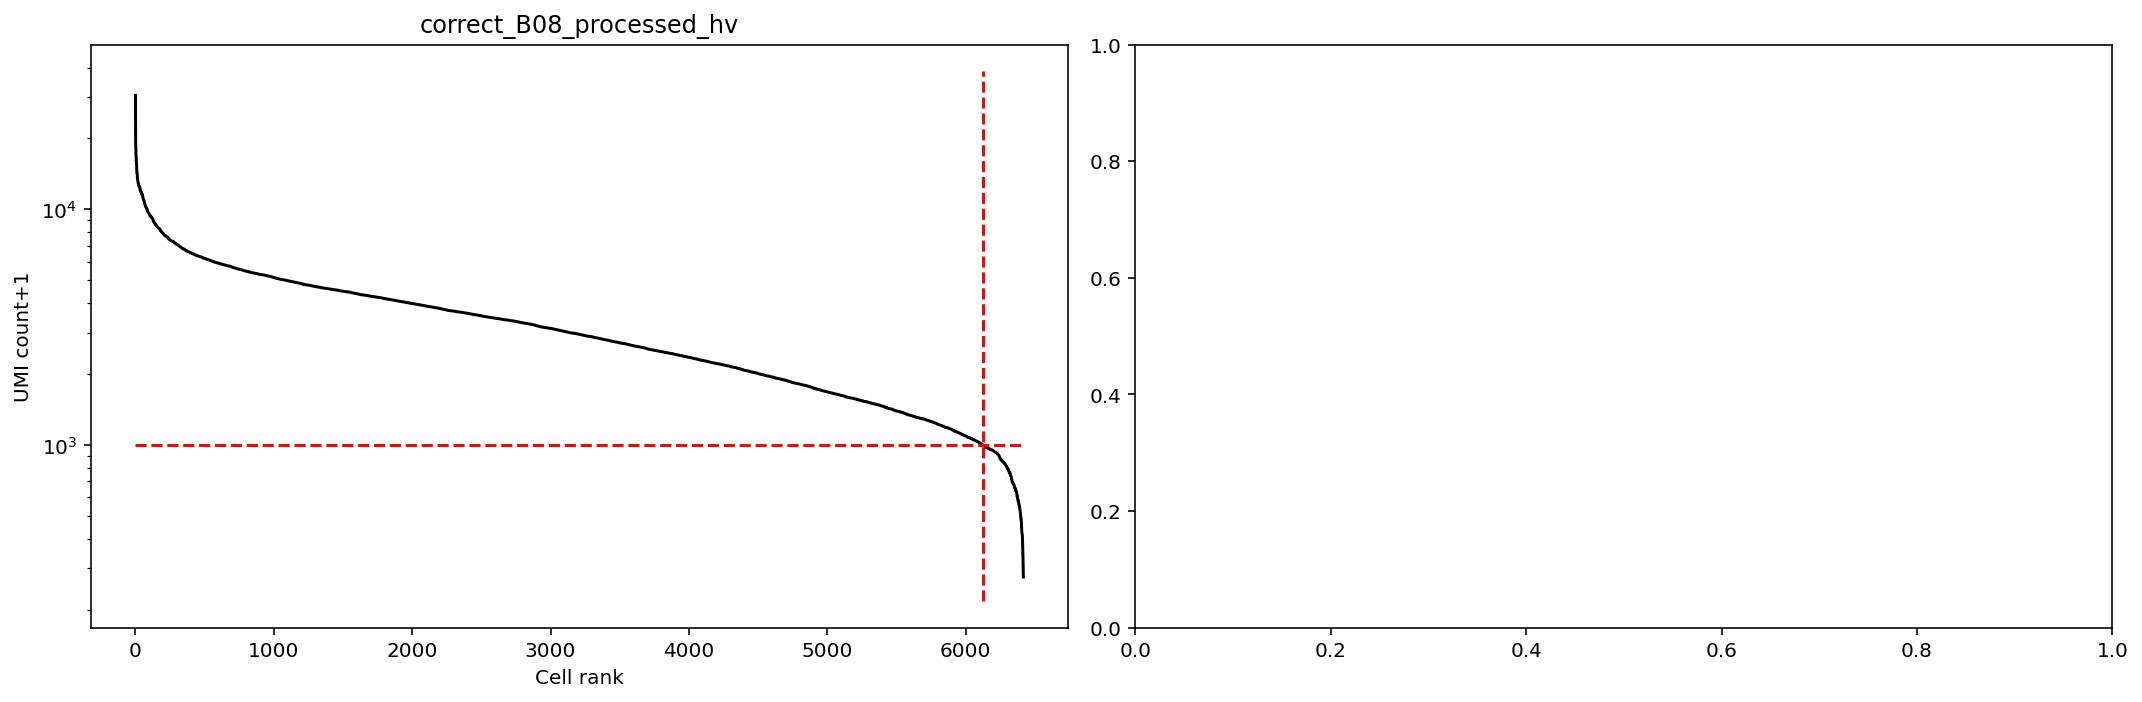

In [133]:
cf = []
thr_lb = [1e3]*len(dataset_meta)*2

fig1,ax1 = plt.subplots(1,len(dataset_meta)*2,figsize=(15,5))

for k in range(len(dataset_meta)):
    filename = loom_filepaths[len(subcluster_names)*k]
    dataset_name = raw_data_locations[len(subcluster_names)*k]
    
    with lp.connect(filename,mode='r') as ds:
        S = ds.layers[spliced_layer][:]
        U = ds.layers[unspliced_layer][:]
        gene_names = ds.ra[gene_attr]
        bcs = ds.ca[cell_attr]
        n_cells = S.shape[1]
        monod.preprocess.knee_plot(S+U,ax1[k],viz=True,thr=thr_lb[k])
        cf_ = ((S+U).sum(0)>thr_lb[k])
        
        n_annot_bcs = meta['cell_barcode'].sum()
        annot_bcs_in_loom = meta['cell_barcode'].isin(bcs).sum()
        annot_bcs_in_filt_loom = meta['cell_barcode'].isin(bcs[cf_]).sum()
        print(f'Dataset {dataset_name}. \n\t{len(bcs)} barcodes in loom, {cf_.sum()} pass filter. {n_annot_bcs} in annotations; of these, {annot_bcs_in_loom} in loom and {annot_bcs_in_filt_loom} in filtered loom.')
        
        #if k==0:
        for subcluster in subcluster_names:
            annot_bcs = meta[(meta['cell_type'].isin(subcluster))]['cell_barcode']
            cf.append(np.isin(bcs,annot_bcs) & cf_)
            print(f'\t{subcluster}: {len(annot_bcs)} cells in annotations. {np.isin(bcs,annot_bcs).sum()} in loom. {cf[-1].sum()} pass filter.')



    ax1[k].set_title(dataset_name)
    
!mkdir ./figs    
fig_dir = './figs/'
fig_string = fig_dir + 'kneeplots_top_allenB08_forMM.png'
fig1.tight_layout()
plt.savefig(fig_string,dpi=450)

In [134]:
all_assigns = [list(meta['cell_type_id'][meta['cell_barcode'] == i])[0] for i in bcs[cf[0]]]
print(len(all_assigns))

2599


## **Gene Filtering**

In [135]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.INFO)

In [136]:
# !mkdir ./fits


INFO:root:Beginning data preprocessing and filtering.
INFO:root:Directory ./fits/gg_230413_025_allen_B08_MM_1 already exists.
INFO:root:Dataset: allen_correct_B08_processed_hv_L6_CT_L2-3_IT_L6_IT_k1
INFO:root:2599 cells detected.
INFO:root:2000 features observed, 1990 match genome annotations. 1978 were unique.
INFO:root:419 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230413_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L6_CT_L2-3_IT_L6_IT_k1 already exists.
INFO:root:Dataset: allen_correct_B08_processed_hv_L6_CT_L2-3_IT_L6_IT_k2
INFO:root:2599 cells detected.
INFO:root:2000 features observed, 1990 match genome annotations. 1978 were unique.
INFO:root:419 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230413_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L6_CT_L2-3_IT_L6_IT_k2 already exists.
INFO:root:Dataset: allen_correct_B08_processed_hv_L6_CT_L2-3_IT_L6_IT_k3
INFO:root:2599 cells detected.
INFO:root:2000 features observed, 19

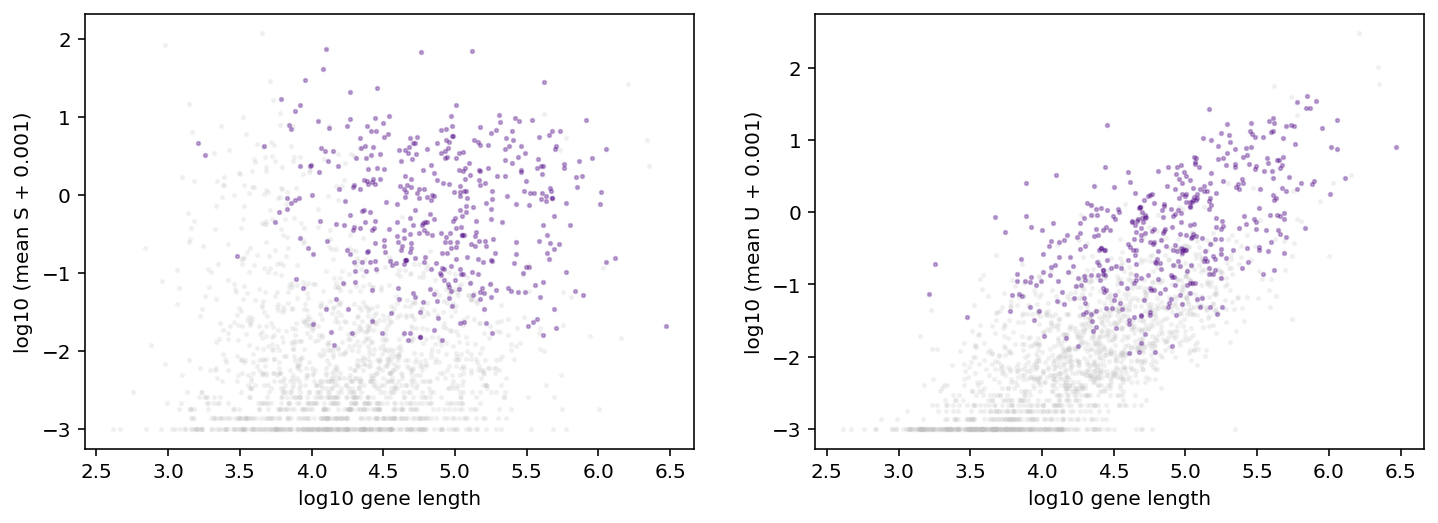

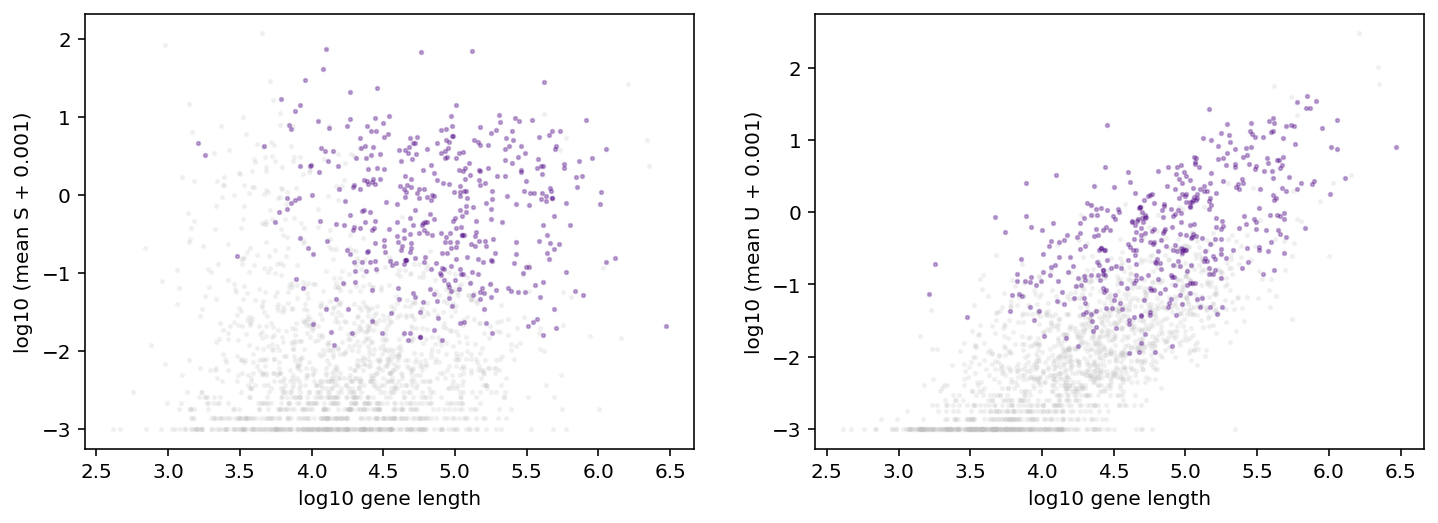

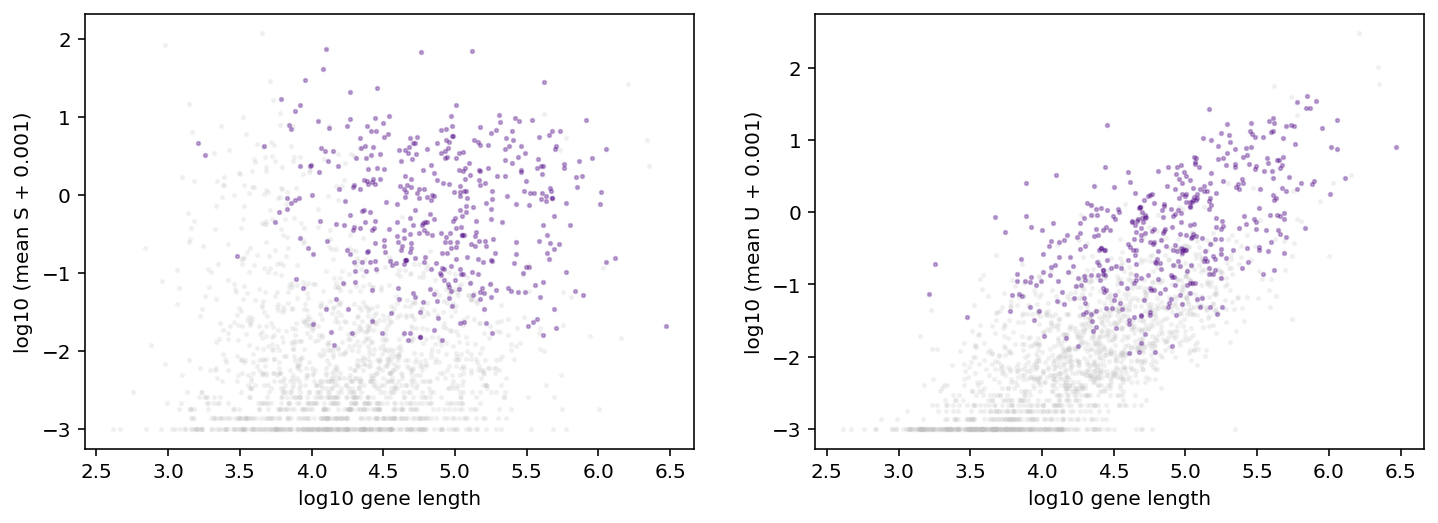

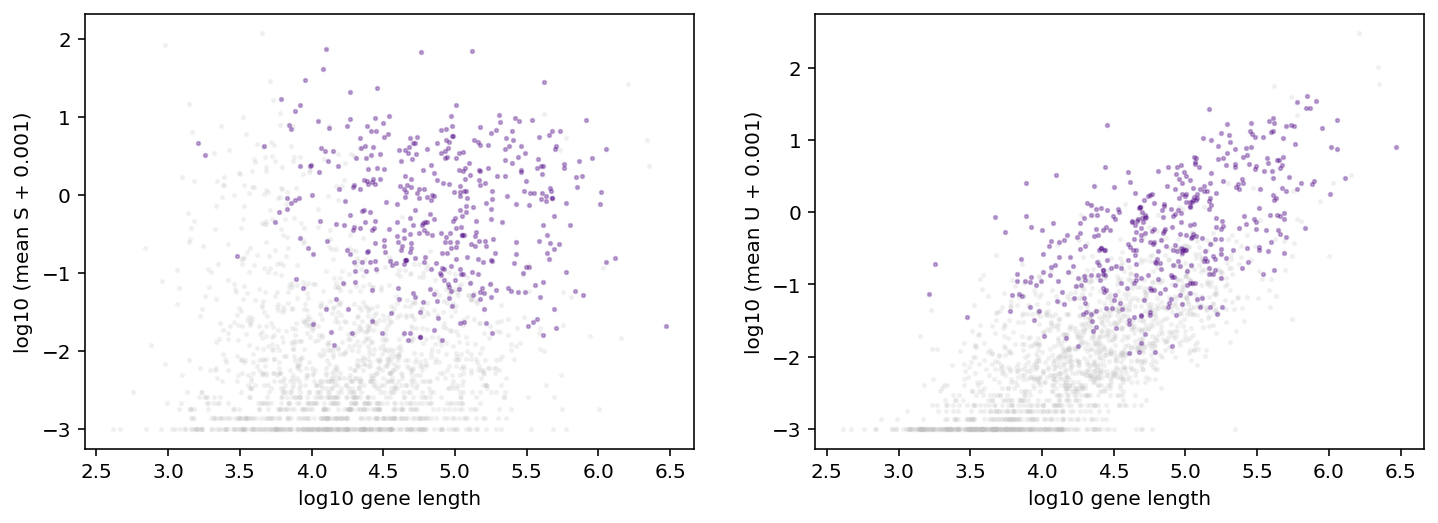

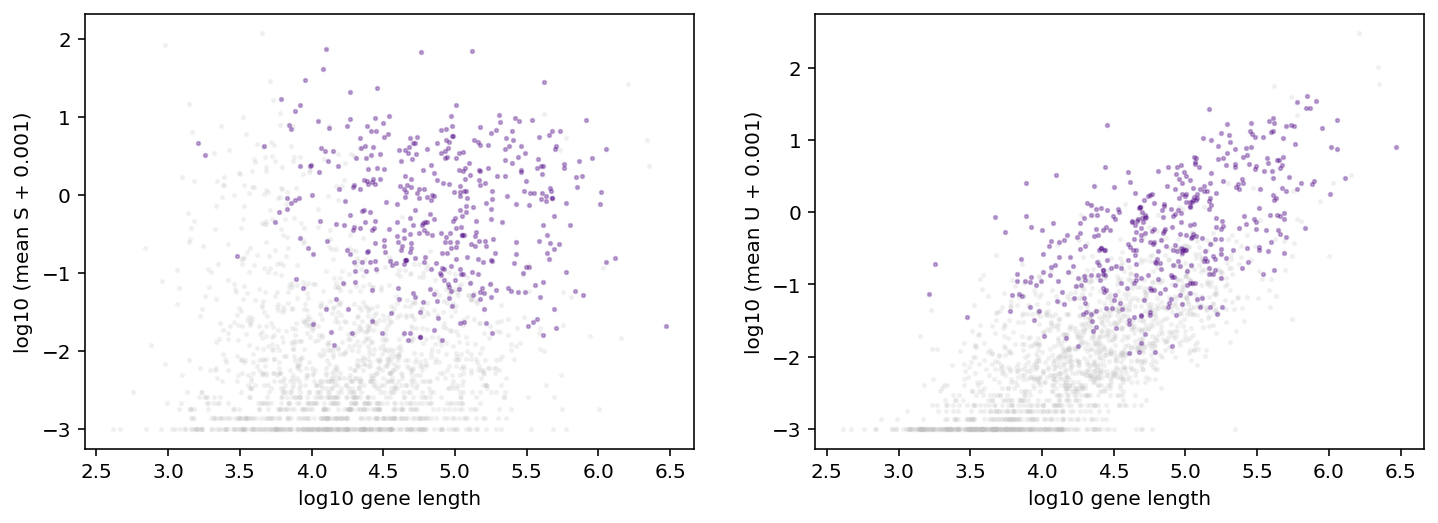

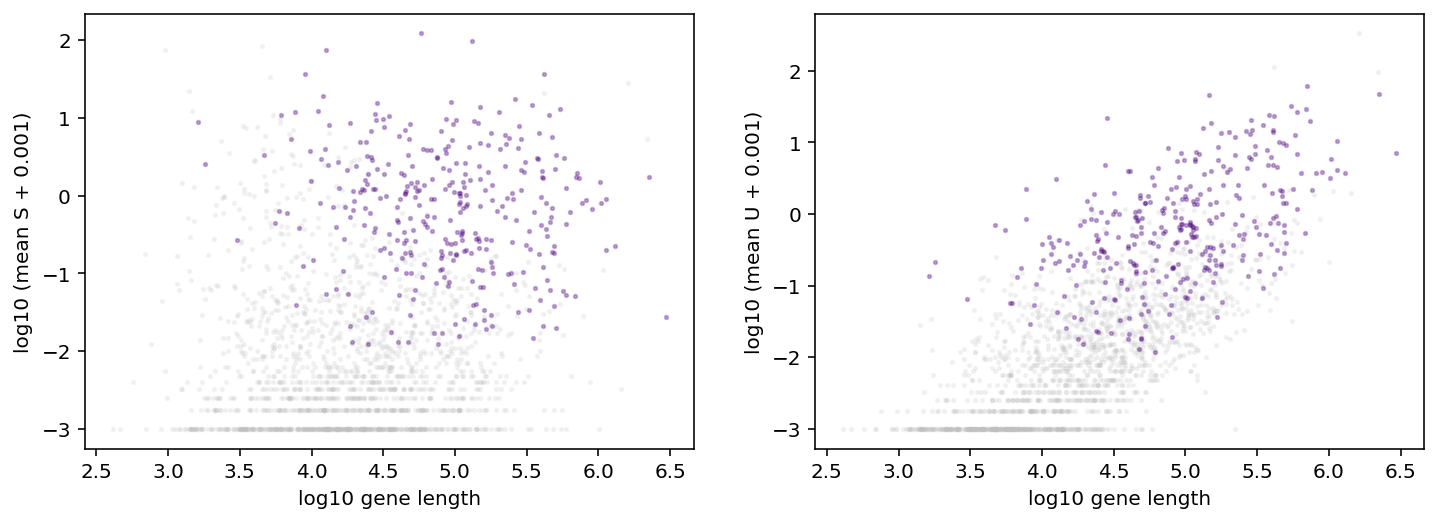

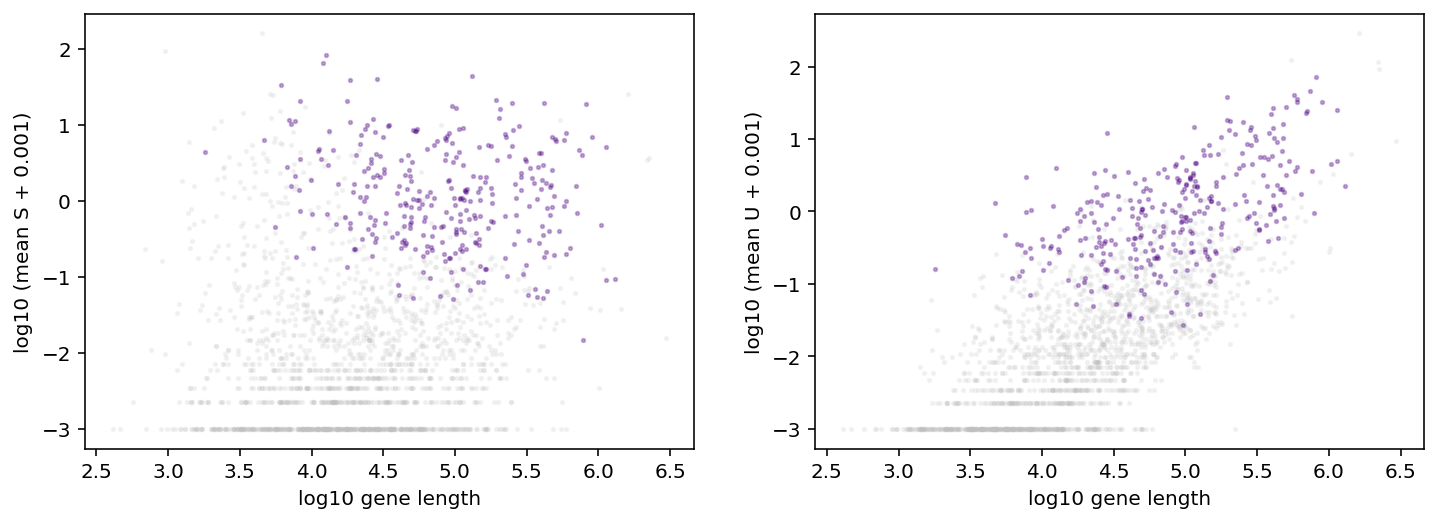

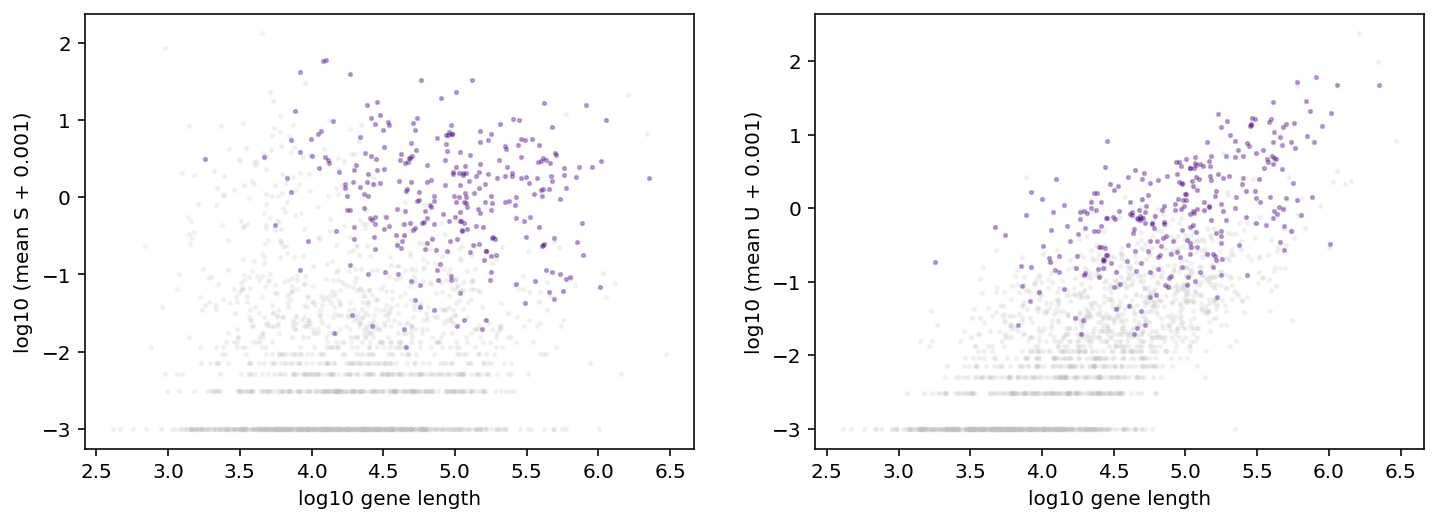

In [137]:
dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./fits',meta='allen_B08_MM',batch_id=1,\
                                             datestring='230413', n_genes=1000,\
                                             exp_filter_threshold=None,cf=cf)

INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_correct_B08_processed_hv_L6_CT_L2-3_IT_L6_IT_k3
INFO:root:2000 features observed, 1990 match genome annotations. 1978 were unique.
INFO:root:Gene list extracted from ./fits/gg_230413_025_allen_B08_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230413_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L6_CT_L2-3_IT_L6_IT_k3/diagnostic_figures already exists.
INFO:root:Search data stored to ./fits/gg_230413_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L6_CT_L2-3_IT_L6_IT_k3/raw.sd.
(2599, 1000)


Text(0.5, 1.0, 'S K-Means Init: allen_correct_B08_processed_hv_L6_CT_L2-3_IT_L6_IT_k3')

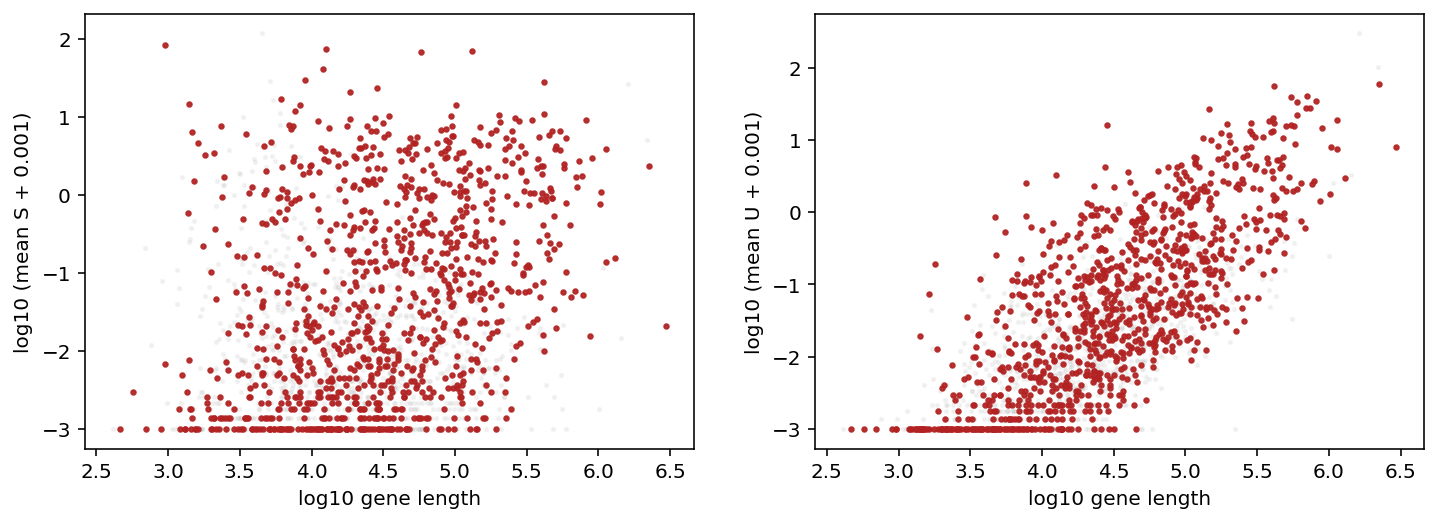

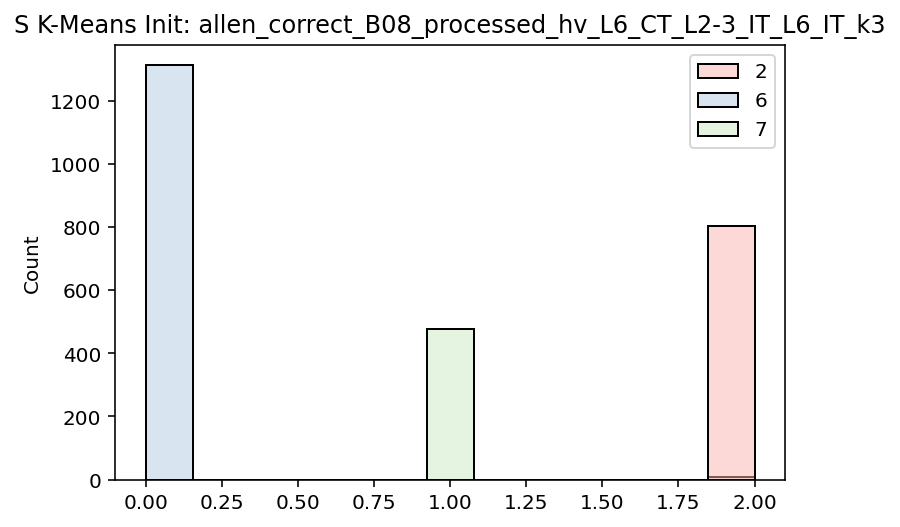

In [138]:
#For easier demonstration
#Check initializations of clusters
which = 2
search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
            dataset_strings[which], dir_string, dataset_attr_names=attribute_names,cf=cf[which])

S = search_data.layers[1,:,:]
S_t = S.T
tots = np.sum(S_t,axis=1)
divids = (1e4/tots)[:,None]
S_t = S_t*divids
S_t = np.log1p(S_t)
print(S_t.shape)

kmeans = KMeans(n_clusters=ks[which], random_state=0).fit(S_t)
labs = kmeans.labels_


labels = labs
plt.figure()
sns.histplot(x=labels,hue=pd.Categorical(all_assigns), kde=False,palette='Pastel1')
plt.title('S K-Means Init: '+dataset_names[which])

    

INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_correct_B08_processed_hv_L6_CT_L2-3_IT_L6_IT_k3
INFO:root:2000 features observed, 1990 match genome annotations. 1978 were unique.
INFO:root:Gene list extracted from ./fits/gg_230413_025_allen_B08_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230413_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L6_CT_L2-3_IT_L6_IT_k3/diagnostic_figures already exists.
INFO:root:Search data stored to ./fits/gg_230413_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L6_CT_L2-3_IT_L6_IT_k3/raw.sd.
(2599, 1000)


Text(0.5, 1.0, 'U K-Means Init: allen_correct_B08_processed_hv_L6_CT_L2-3_IT_L6_IT_k3')

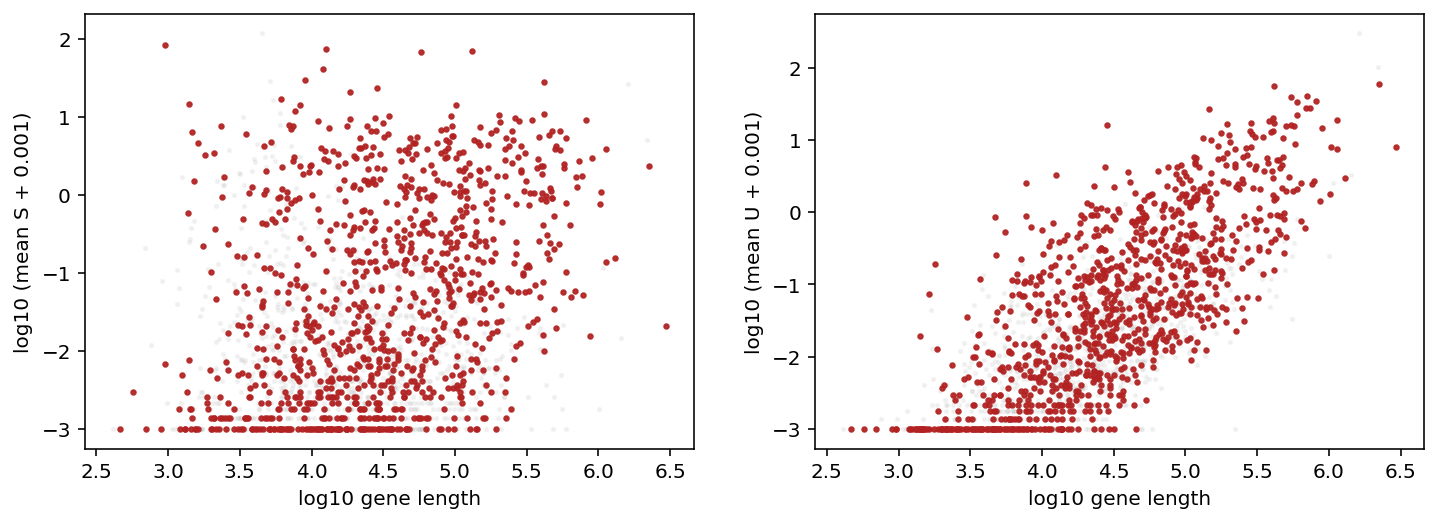

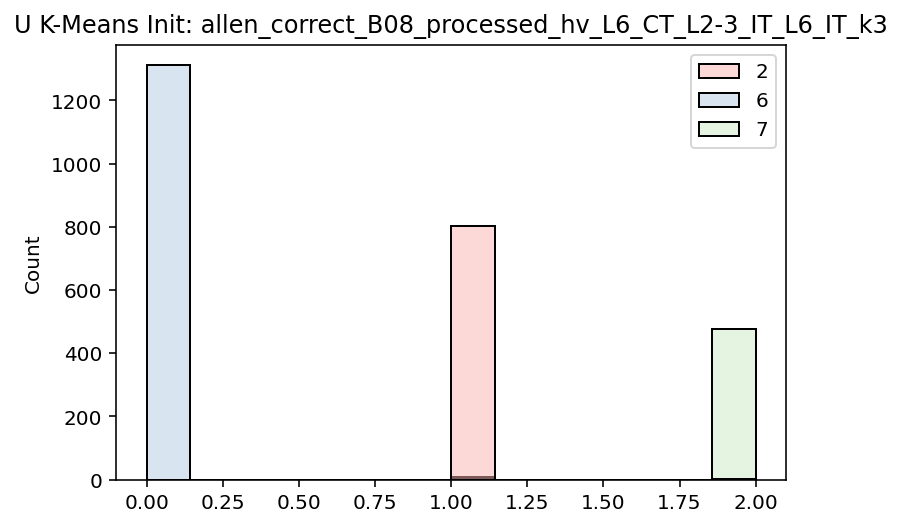

In [139]:
#Unspliced
which = 2
search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
            dataset_strings[which], dir_string, dataset_attr_names=attribute_names,cf=cf[which])

S = search_data.layers[0,:,:]
S_t = S.T
tots = np.sum(S_t,axis=1)
divids = (1e4/tots)[:,None]
S_t = S_t*divids
S_t = np.log1p(S_t)
print(S_t.shape)

kmeans = KMeans(n_clusters=ks[which], random_state=0).fit(S_t)
labs = kmeans.labels_


labels = labs
plt.figure()
sns.histplot(x=labels,hue=pd.Categorical(all_assigns), kde=False,palette='Pastel1')
plt.title('U K-Means Init: '+dataset_names[which])

    

INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_correct_B08_processed_hv_L5_IT_L2-3_IT_L6_IT_k3
INFO:root:2000 features observed, 1990 match genome annotations. 1978 were unique.
INFO:root:Gene list extracted from ./fits/gg_230413_025_allen_B08_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230413_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L5_IT_L2-3_IT_L6_IT_k3/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_230413_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L5_IT_L2-3_IT_L6_IT_k3/raw.sd.
(3493, 1000)


Text(0.5, 1.0, 'S K-Means Init: allen_correct_B08_processed_hv_L5_IT_L2-3_IT_L6_IT_k3')

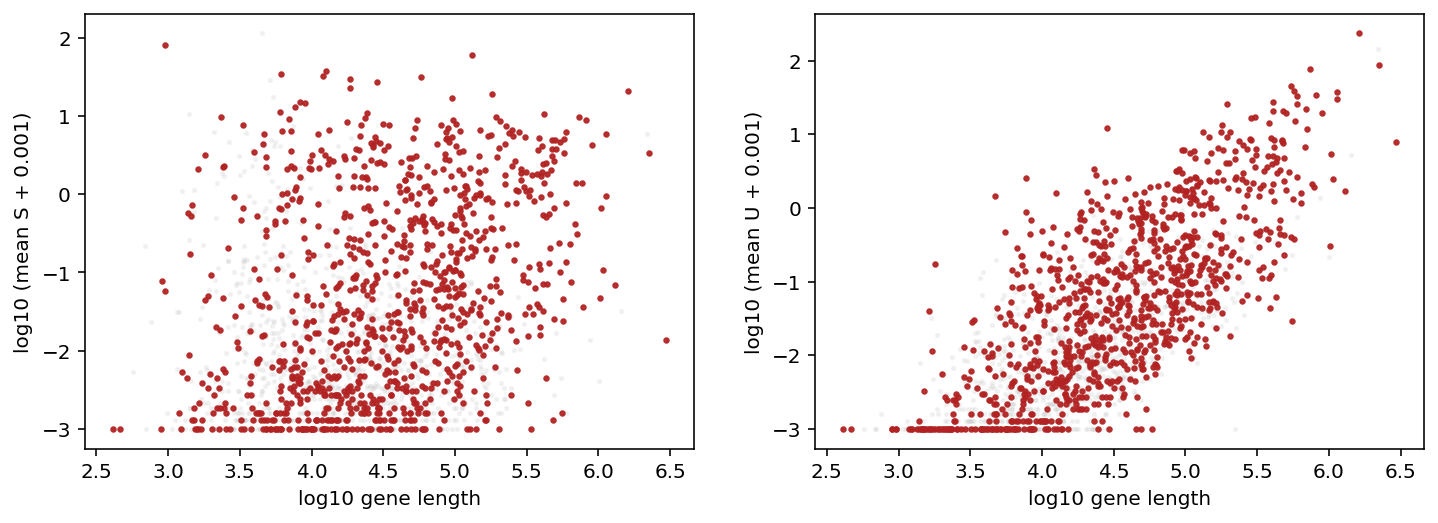

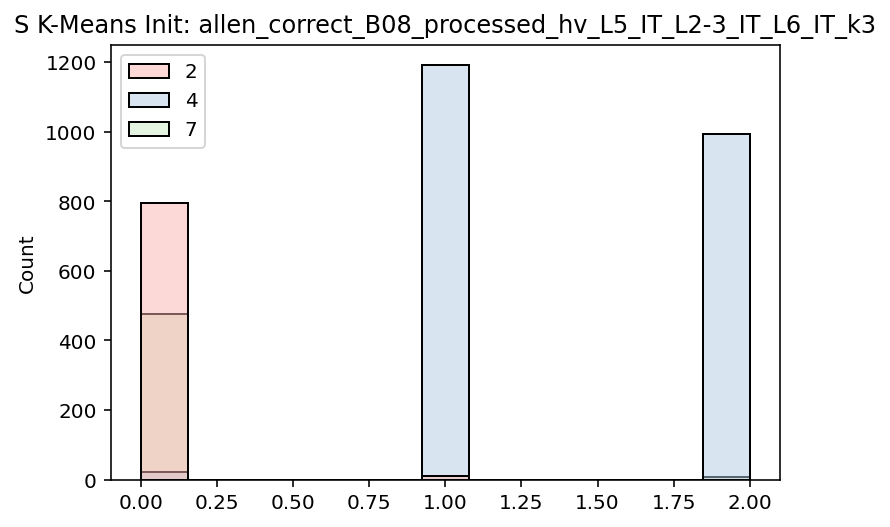

In [112]:
#Check initializations of clusters
which = 2
search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
            dataset_strings[which], dir_string, dataset_attr_names=attribute_names,cf=cf[which])

S = search_data.layers[1,:,:]
S_t = S.T
tots = np.sum(S_t,axis=1)
divids = (1e4/tots)[:,None]
S_t = S_t*divids
S_t = np.log1p(S_t)
print(S_t.shape)

kmeans = KMeans(n_clusters=ks[which], random_state=0).fit(S_t)
labs = kmeans.labels_


labels = labs
plt.figure()
sns.histplot(x=labels,hue=pd.Categorical(all_assigns), kde=False,palette='Pastel1')
plt.title('S K-Means Init: '+dataset_names[which])

    

INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_correct_B08_processed_hv_L5_IT_L2-3_IT_L6_IT_k3
INFO:root:2000 features observed, 1990 match genome annotations. 1978 were unique.
INFO:root:Gene list extracted from ./fits/gg_230413_025_allen_B08_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230413_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L5_IT_L2-3_IT_L6_IT_k3/diagnostic_figures already exists.
INFO:root:Search data stored to ./fits/gg_230413_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L5_IT_L2-3_IT_L6_IT_k3/raw.sd.
(3493, 1000)


Text(0.5, 1.0, 'U K-Means Init: allen_correct_B08_processed_hv_L5_IT_L2-3_IT_L6_IT_k3')

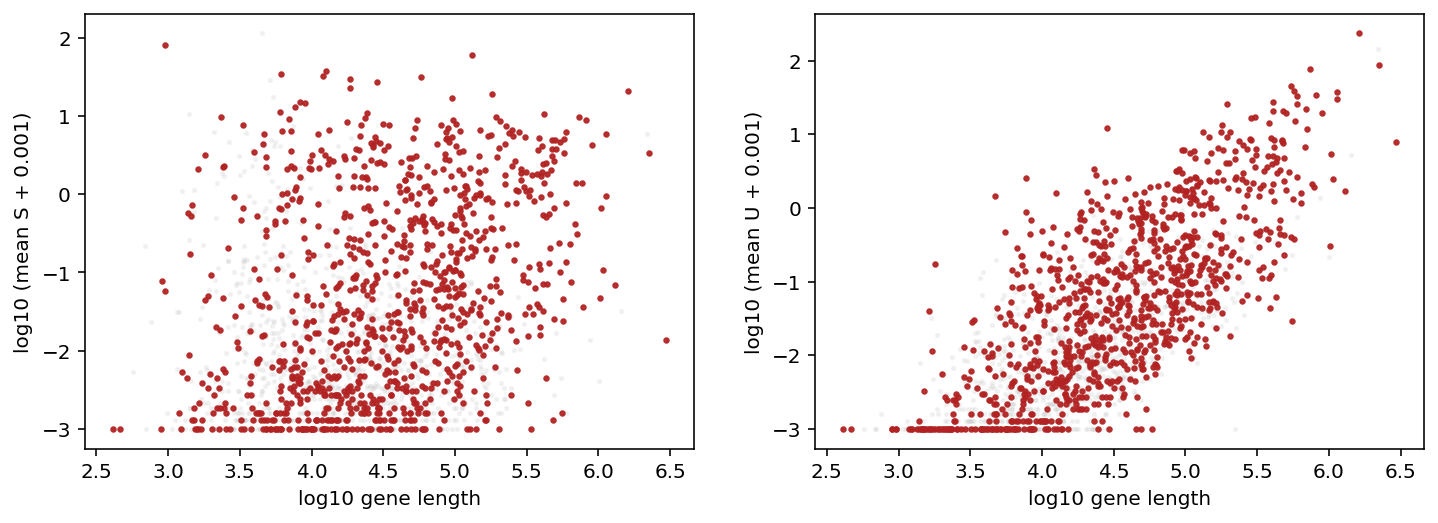

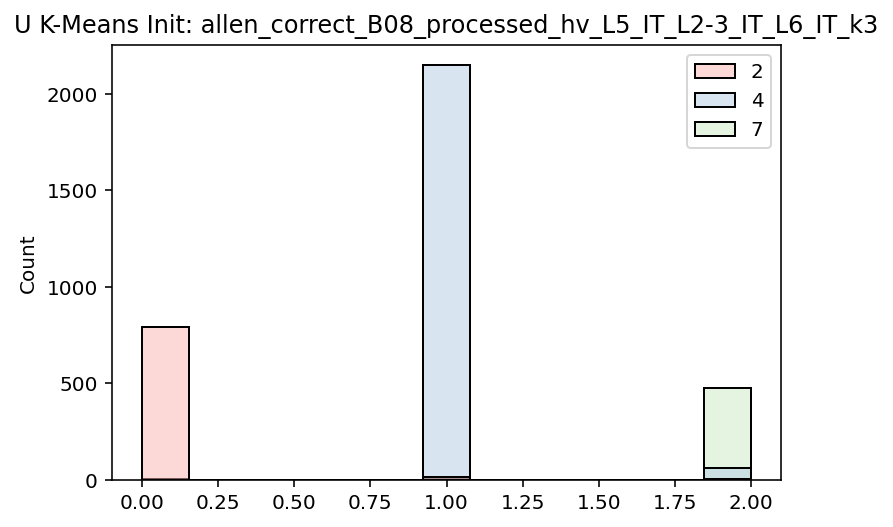

In [113]:
#Unspliced
which = 2
search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
            dataset_strings[which], dir_string, dataset_attr_names=attribute_names,cf=cf[which])

S = search_data.layers[0,:,:]
S_t = S.T
tots = np.sum(S_t,axis=1)
divids = (1e4/tots)[:,None]
S_t = S_t*divids
S_t = np.log1p(S_t)
print(S_t.shape)

kmeans = KMeans(n_clusters=ks[which], random_state=0).fit(S_t)
labs = kmeans.labels_


labels = labs
plt.figure()
sns.histplot(x=labels,hue=pd.Categorical(all_assigns), kde=False,palette='Pastel1')
plt.title('U K-Means Init: '+dataset_names[which])

    

## **Run MM/Monod Inference**

v----------- Only Run Once -----------v

In [78]:
#Define bounds, 
phys_lb = [-2.0, -1.8, -1.8 ] #-1.0, -1.8, -1.8
phys_ub = [4.2, 2.5, 2.5] #4.2, 2.5, 3.5
samp_lb = [-9, -4] #-7.5, -2
samp_ub = [-4, 1.5] #-5.5, 0
# gridsize = [5,6]
gridsize = [10,11]


INFO:root:Directory ./fits/gg_230413_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L6_CT/Bursty_Poisson_10x11 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230413_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L6_CT/Bursty_Poisson_10x11/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_correct_B08_processed_hv_L6_CT
INFO:root:2000 features observed, 1990 match genome annotations. 1978 were unique.
INFO:root:Gene list extracted from ./fits/gg_230413_025_allen_B08_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230413_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L6_CT/diagnostic_figures already exists.
INFO:root:Search data stored to ./fits/gg_230413_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L6_CT/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [08:16<00:00,  4.51s/it]

INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230413_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L6_CT/Bursty_Poisson_10x11/analysis_figures already exists.
INFO:root:Runtime: 497.1 seconds.
INFO:root:Directory ./fits/gg_230413_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L2-3_IT/Bursty_Poisson_10x11 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230413_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L2-3_IT/Bursty_Poisson_10x11/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_correct_B08_processed_hv_L2-3_IT


INFO:root:2000 features observed, 1990 match genome annotations. 1978 were unique.
INFO:root:Gene list extracted from ./fits/gg_230413_025_allen_B08_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230413_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L2-3_IT/diagnostic_figures already exists.
INFO:root:Search data stored to ./fits/gg_230413_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L2-3_IT/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [08:29<00:00,  4.63s/it]

INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230413_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L2-3_IT/Bursty_Poisson_10x11/analysis_figures already exists.
INFO:root:Runtime: 510.2 seconds.


INFO:root:Directory ./fits/gg_230413_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L6_IT/Bursty_Poisson_10x11 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230413_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L6_IT/Bursty_Poisson_10x11/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_correct_B08_processed_hv_L6_IT
INFO:root:2000 features observed, 1990 match genome annotations. 1978 were unique.
INFO:root:Gene list extracted from ./fits/gg_230413_025_allen_B08_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230413_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L6_IT/diagnostic_figures already exists.
INFO:root:Search data stored to ./fits/gg_230413_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L6_IT/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [05:18<00:00,  2.90s/it]

INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230413_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L6_IT/Bursty_Poisson_10x11/analysis_figures already exists.
INFO:root:Runtime: 319.2 seconds.


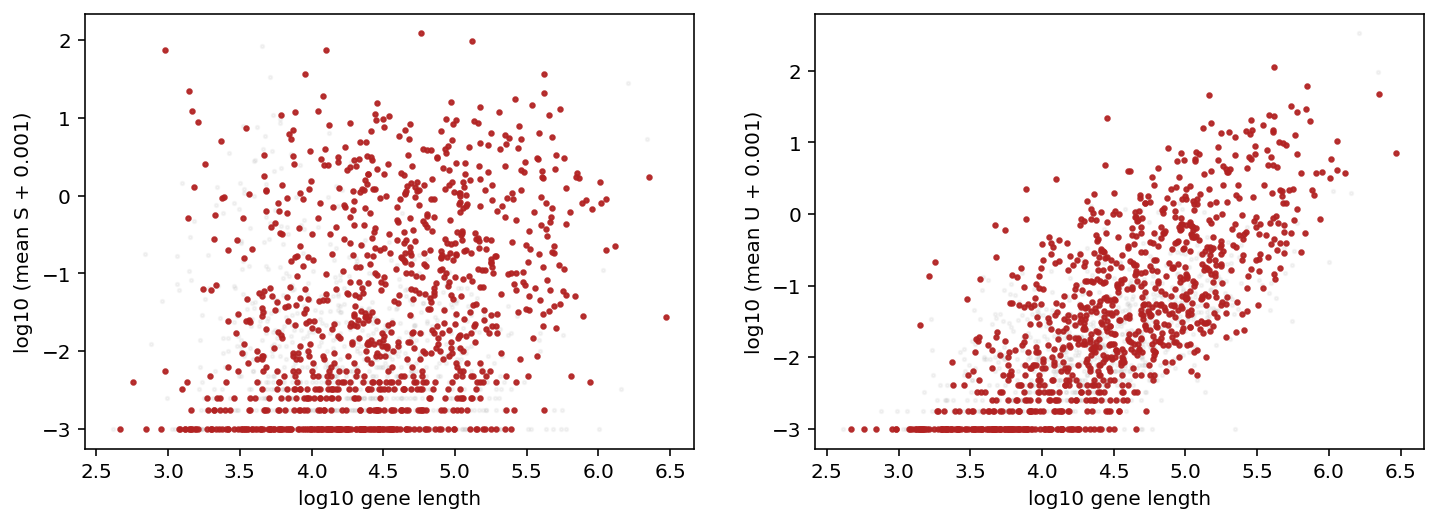

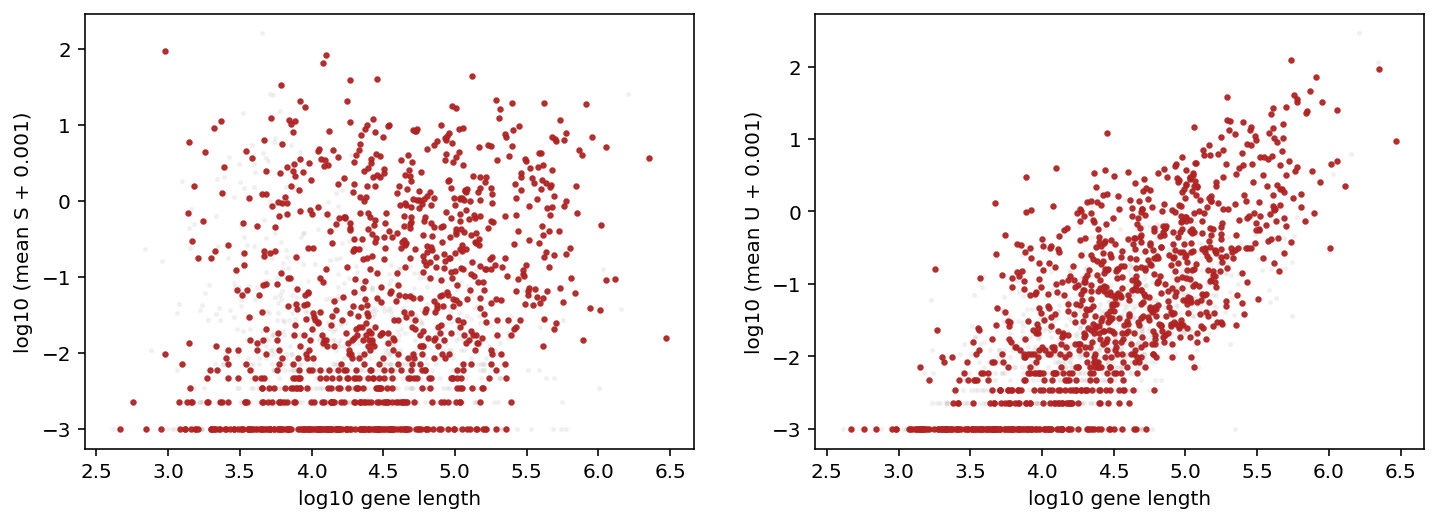

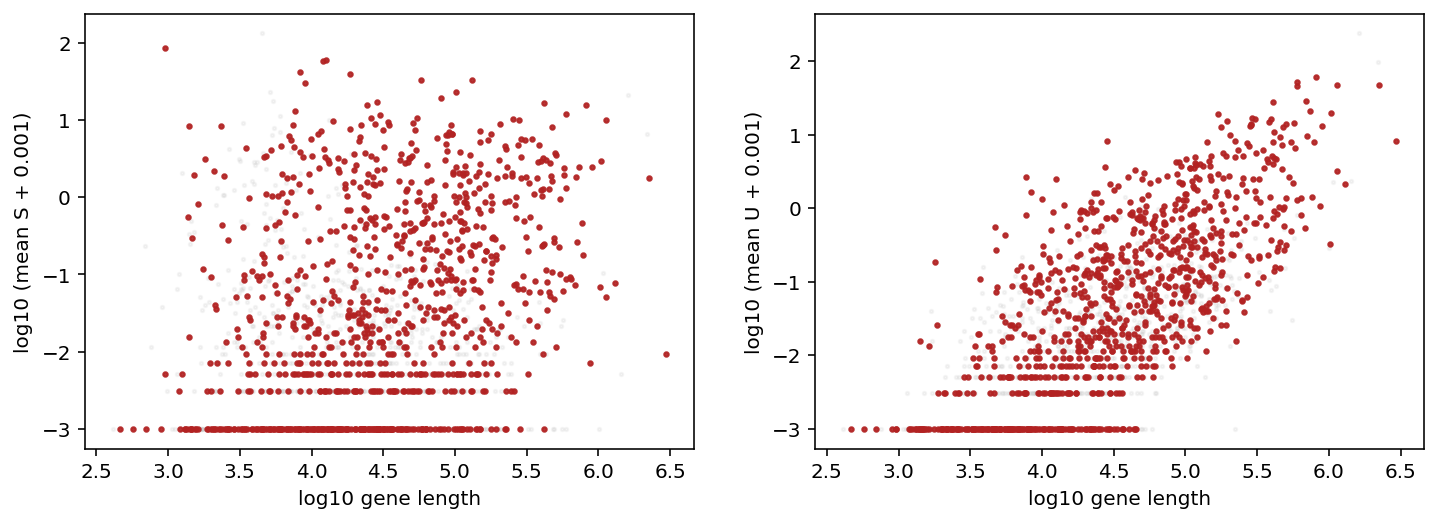

In [79]:
#Run Monod as control on separate groups
result_strings = []
#for i in range(1,2): #n_datasets
for i in range(5,len(dataset_names)):

    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')

    inference_parameters = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,use_lengths = True,
                gradient_params = {'max_iterations':20,'init_pattern':'moments','num_restarts':1})

    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, dataset_attr_names=attribute_names,cf=cf[i])

    full_result_string = inference_parameters.fit_all_grid_points(30,search_data)

    result_strings.append(full_result_string)

In [81]:
result_strings = [i+'/Bursty_Poisson_10x11/grid_scan_results.res' for i in dataset_strings[5:len(dataset_names)]]

INFO:root:Grid scan results loaded from ./fits/gg_230413_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L6_CT/Bursty_Poisson_10x11/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230413_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L2-3_IT/Bursty_Poisson_10x11/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230413_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L6_IT/Bursty_Poisson_10x11/grid_scan_results.res.


Text(0, 0.5, '$\\log_{10} \\lambda_M$')

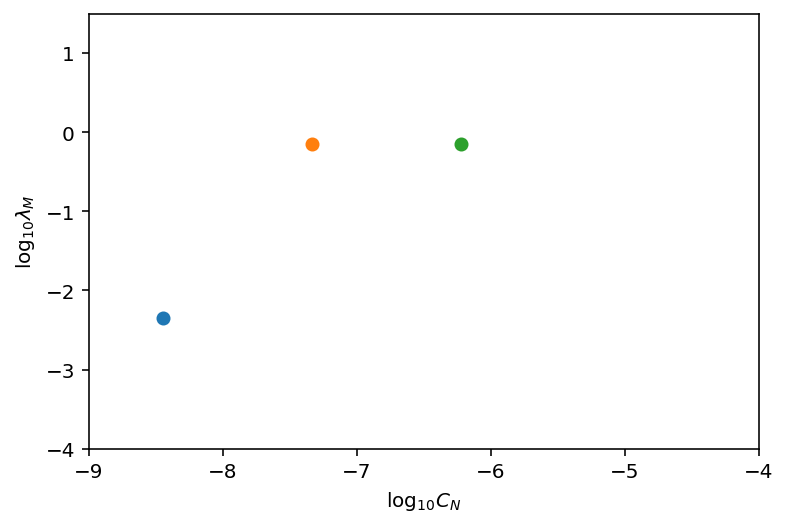

In [82]:
sr = [monod.analysis.load_search_results(i) for i in result_strings]
plt.figure()
for r in sr:
    r.find_sampling_optimum()
    plt.scatter(r.samp_optimum[0],r.samp_optimum[1])
    
plt.xlim([-9,-4])
plt.ylim([-4,1.5])

plt.xlabel(r'$\log_{10} C_N$')
plt.ylabel(r'$\log_{10} \lambda_M$')

In [83]:
inference_parameters.X

array([-9.        , -9.        , -9.        , -9.        , -9.        ,
       -9.        , -9.        , -9.        , -9.        , -9.        ,
       -9.        , -8.44444444, -8.44444444, -8.44444444, -8.44444444,
       -8.44444444, -8.44444444, -8.44444444, -8.44444444, -8.44444444,
       -8.44444444, -8.44444444, -7.88888889, -7.88888889, -7.88888889,
       -7.88888889, -7.88888889, -7.88888889, -7.88888889, -7.88888889,
       -7.88888889, -7.88888889, -7.88888889, -7.33333333, -7.33333333,
       -7.33333333, -7.33333333, -7.33333333, -7.33333333, -7.33333333,
       -7.33333333, -7.33333333, -7.33333333, -7.33333333, -6.77777778,
       -6.77777778, -6.77777778, -6.77777778, -6.77777778, -6.77777778,
       -6.77777778, -6.77777778, -6.77777778, -6.77777778, -6.77777778,
       -6.22222222, -6.22222222, -6.22222222, -6.22222222, -6.22222222,
       -6.22222222, -6.22222222, -6.22222222, -6.22222222, -6.22222222,
       -6.22222222, -5.66666667, -5.66666667, -5.66666667, -5.66

In [84]:
inference_parameters.Y

array([-4.  , -3.45, -2.9 , -2.35, -1.8 , -1.25, -0.7 , -0.15,  0.4 ,
        0.95,  1.5 , -4.  , -3.45, -2.9 , -2.35, -1.8 , -1.25, -0.7 ,
       -0.15,  0.4 ,  0.95,  1.5 , -4.  , -3.45, -2.9 , -2.35, -1.8 ,
       -1.25, -0.7 , -0.15,  0.4 ,  0.95,  1.5 , -4.  , -3.45, -2.9 ,
       -2.35, -1.8 , -1.25, -0.7 , -0.15,  0.4 ,  0.95,  1.5 , -4.  ,
       -3.45, -2.9 , -2.35, -1.8 , -1.25, -0.7 , -0.15,  0.4 ,  0.95,
        1.5 , -4.  , -3.45, -2.9 , -2.35, -1.8 , -1.25, -0.7 , -0.15,
        0.4 ,  0.95,  1.5 , -4.  , -3.45, -2.9 , -2.35, -1.8 , -1.25,
       -0.7 , -0.15,  0.4 ,  0.95,  1.5 , -4.  , -3.45, -2.9 , -2.35,
       -1.8 , -1.25, -0.7 , -0.15,  0.4 ,  0.95,  1.5 , -4.  , -3.45,
       -2.9 , -2.35, -1.8 , -1.25, -0.7 , -0.15,  0.4 ,  0.95,  1.5 ,
       -4.  , -3.45, -2.9 , -2.35, -1.8 , -1.25, -0.7 , -0.15,  0.4 ,
        0.95,  1.5 ])

^----------- Only Run Once -----------^

In [141]:
#Define bounds, choose 'centroid'
phys_lb = [-2.0, -1.8, -1.8 ] #-1.0, -1.8, -1.8
phys_ub = [4.2, 2.5, 2.5] #4.2, 2.5, 3.5
samp_lb = [-7.33333333, -1.25] #-7.5, -2
samp_ub = [-7.33333333, -1.25] #-5.5, 0
# gridsize = [5,6]
gridsize = [1,1]


In [ ]:
#Run Monod as control on separate groups
result_strings = []
#for i in range(1,2): #n_datasets
for i in range(5,len(dataset_names)):

    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')

    inference_parameters = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,use_lengths = True,
                gradient_params = {'max_iterations':20,'init_pattern':'moments','num_restarts':1})

    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, dataset_attr_names=attribute_names,cf=cf[i])

    full_result_string = inference_parameters.fit_all_grid_points(30,search_data)

    result_strings.append(full_result_string)
    
result_strings = [i+'/Bursty_Poisson_1x1/grid_scan_results.res' for i in dataset_strings[5:len(dataset_names)]]

**Mixture Model**

In [142]:
epochs = 10

INFO:root:Directory ./fits/gg_230413_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L6_CT_L2-3_IT_L6_IT_k5/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230413_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L6_CT_L2-3_IT_L6_IT_k5/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_correct_B08_processed_hv_L6_CT_L2-3_IT_L6_IT_k5
INFO:root:2000 features observed, 1990 match genome annotations. 1978 were unique.
INFO:root:Gene list extracted from ./fits/gg_230413_025_allen_B08_MM_1/genes.csv.
INFO:root:Directory ./fits/gg_230413_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L6_CT_L2-3_IT_L6_IT_k5/diagnostic_figures already exists.
INFO:root:Search data stored to ./fits/gg_230413_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L6_CT_L2-3_IT_L6_IT_k5/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:05<00:00, 25.05s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:01<00:00, 24.29s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.01815012 0.48250103 0.01682258 0.29326089 0.18926538]
Q Function:  -3518807.237931385

INFO:root:EM Epoch 2/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [02:06<00:00, 31.63s/it]

INFO:root:Parallelized MLE fits complete.


mstep self.weights:  [2.69113299e-03 5.03279547e-01 3.84763370e-10 2.45638232e-01
 2.48391087e-01]
Q Function:  -3435262.662297381

INFO:root:EM Epoch 3/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:59<00:00, 29.89s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.15429049e-03 5.03270488e-01 3.84763370e-10 2.38221699e-01
 2.57353522e-01]
Q Function:  -3404084.809947317

INFO:root:EM Epoch 4/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:10<00:00, 43.41s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.84763370e-10 5.03270488e-01 3.84763370e-10 2.31253849e-01
 2.65475662e-01]
Q Function:  -3397293.504252961

INFO:root:EM Epoch 5/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:06<00:00, 42.26s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.84763370e-10 5.03270488e-01 3.84763370e-10 1.89144023e-01
 3.07585488e-01]
Q Function:  -3414334.9471817366

INFO:root:EM Epoch 6/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:07<00:00, 42.53s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.84763370e-10 5.03270488e-01 3.84763370e-10 1.76395290e-01
 3.20334221e-01]
Q Function:  -3347097.8041592273

INFO:root:EM Epoch 7/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:06<00:00, 42.15s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.84763370e-10 5.03275324e-01 3.84763370e-10 1.76893052e-01
 3.19831623e-01]
Q Function:  -3426064.282780619

INFO:root:EM Epoch 8/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:12<00:00, 44.08s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.84763370e-10 5.03658407e-01 3.84763370e-10 1.70345435e-01
 3.25996157e-01]
Q Function:  -3435026.3110388867

INFO:root:EM Epoch 9/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:02<00:00, 40.79s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.84763370e-10 5.05156966e-01 3.84763370e-10 1.03829029e-01
 3.91014004e-01]
Q Function:  -3445655.901257666

INFO:root:EM Epoch 10/10: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:03<00:00, 41.06s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.84763370e-10 5.03655255e-01 3.84763370e-10 5.18285101e-02
 4.44516234e-01]
Q Function:  -3405596.221506739

INFO:root:Non-parallelized grid scan complete.


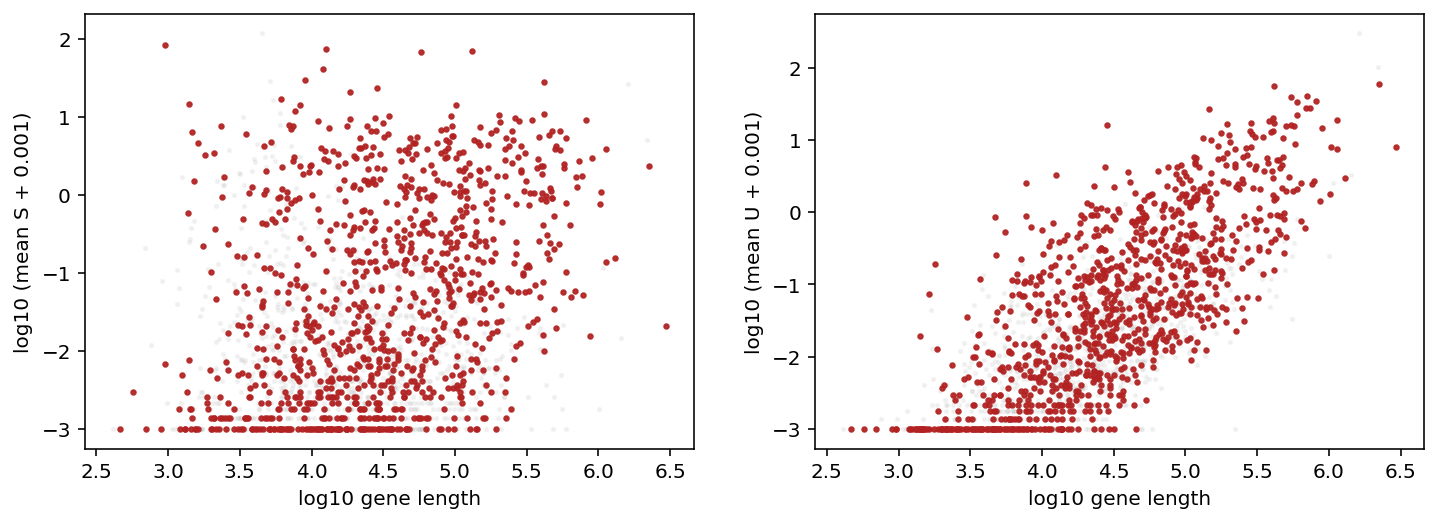

In [150]:
result_strings = []
for i in range(4,5): #range(len(ks)-2): #n_datasets, running data with all clusters
    
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')
    
    inference_parameters = monod.mminference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,k=ks[i],epochs=epochs,use_lengths = True,
                gradient_params = {'max_iterations':20,'init_pattern':'moments','num_restarts':1})
    
    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, dataset_attr_names=attribute_names,cf=cf[i])
    
    inference_parameters.fit_all_grid_points(50,search_data)


## **Analysis of Results**

In [125]:
#Plot cluster concordance with true labels and distribution of clusters 
def vis_assign(true,assign,title='',figsize=(18, 5)):
    true_dict = dict(zip(np.unique(list(true)),range(len(np.unique(list(true))))))
    true = [true_dict[x] for x in true]                
    
    true_copy = list(true)

    
    assign_copy = list(assign)
    if np.max(assign) > np.max(true): #FIX
        for a in np.unique(assign):
            if a > np.max(true):
                true_copy += [a]
                assign_copy += [a]
    true_copy = np.array(true_copy)
    assign_copy = np.array(assign_copy)
    
    conmat = confusion_matrix(true_copy, assign_copy)
    val = np.mat(conmat) 
    classnames = list(set(true_copy))
    df_cm = pd.DataFrame(

            val, index=classnames, columns=classnames, 

        )
    
    if np.max(assign) > np.max(true): #FIX
        for a in np.unique(assign):
            if a > np.max(true):
                print(df_cm.shape)
                df_cm.loc[a,a] = df_cm.loc[a,a]-1

    #Plot assignment distributions
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    
    sns.histplot(x=assign,hue=true, kde=False,ax=ax[0],palette='Pastel1')
    ax[0].set_xlabel('MM Assignment')
    ax[0].set_title(title)
    
    #Plot confustion matrix
    heatmap = sns.heatmap(df_cm, annot=True, cmap=sns.color_palette("light:#5A9", as_cmap=True),ax=ax[1])
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0)
    ax[1].set_ylabel('Original label')
    ax[1].set_xlabel('Assigned label')
    
    
    plt.show()

    

In [126]:
#Plot  aics and loss over time for each k iteration

def vis_metrics(results,title,figsize=(18, 5),s=50):
    num_ks = len(results)
    sets = []
    nlls = []
    res = pd.DataFrame()
    aics = pd.DataFrame()
    klds = pd.DataFrame()
    
    aic = []
    fin_k = []
    kls = []
    
    epoch = len(results[0].all_qs)
    epos = list(range(1,epoch+1))*num_ks
    
    for i in range(num_ks):
        
        nlls += list(-1*np.array(results[i].all_qs))
        sets += [i+1]*epoch
        aic += [results[i].aic] #-2*n_cells*clus
        fin_k += [len(np.unique(results[i].assigns))]
        #kls += [np.mean([np.mean(results[i].klds[:,k]) for k in np.unique(results[i].assigns)])]
        
        kls += list(np.median(np.median(np.array(results[i].all_klds)[:,list(np.unique(results[i].assigns))],axis=2),axis=1))
        
        
    
    
    
    res['NLL'] = nlls
    res['KLD'] = kls
    res['epoch'] = epos
    res['setting'] = ['k='+str(j) for j in sets]
    
    aics['AIC'] = aic
    aics['k'] = [str(j) for j in np.array(range(num_ks))+1 ]
    aics['fin_k'] = fin_k
    

    
    
    #Plot klds over time
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    
    sns.lineplot(data=res,x='epoch',y='NLL',hue='setting', 
                    ax=ax[0],palette='Dark2',
                   alpha=0.7,legend=False)
    sns.scatterplot(data=res,x='epoch',y='NLL',hue='setting', 
                    ax=ax[0],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('NLL')
    ax[0].set_title(title)
    
    
    #Plot klds
    sns.lineplot(data=res,x='epoch',y='KLD',hue='setting', 
                    ax=ax[1],palette='Dark2',
                   alpha=0.7,legend=False)
    sns.scatterplot(data=res,x='epoch',y='KLD',hue='setting', 
                    ax=ax[1],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('KLD')

    
    
    #Plot aics
    sns.scatterplot(data=aics,x='fin_k',y='AIC',hue='k', ax=ax[2],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[2].set_xlabel('Final k')
    ax[2].set_ylabel('-AIC')
    ax[2].legend(
          title='k')
    
    
 
    plt.show()
    
    
    


In [151]:
#Mixture Model results
import pickle 
results = [i+'/Bursty_Poisson_1x1/grid_point_0.gp' for i in [dataset_strings[2],dataset_strings[4]]]
grid_point_results = []
for r in results:
    with open(r, "rb") as ipfs:
        grid_point_results += [pickle.load(ipfs)]

    

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


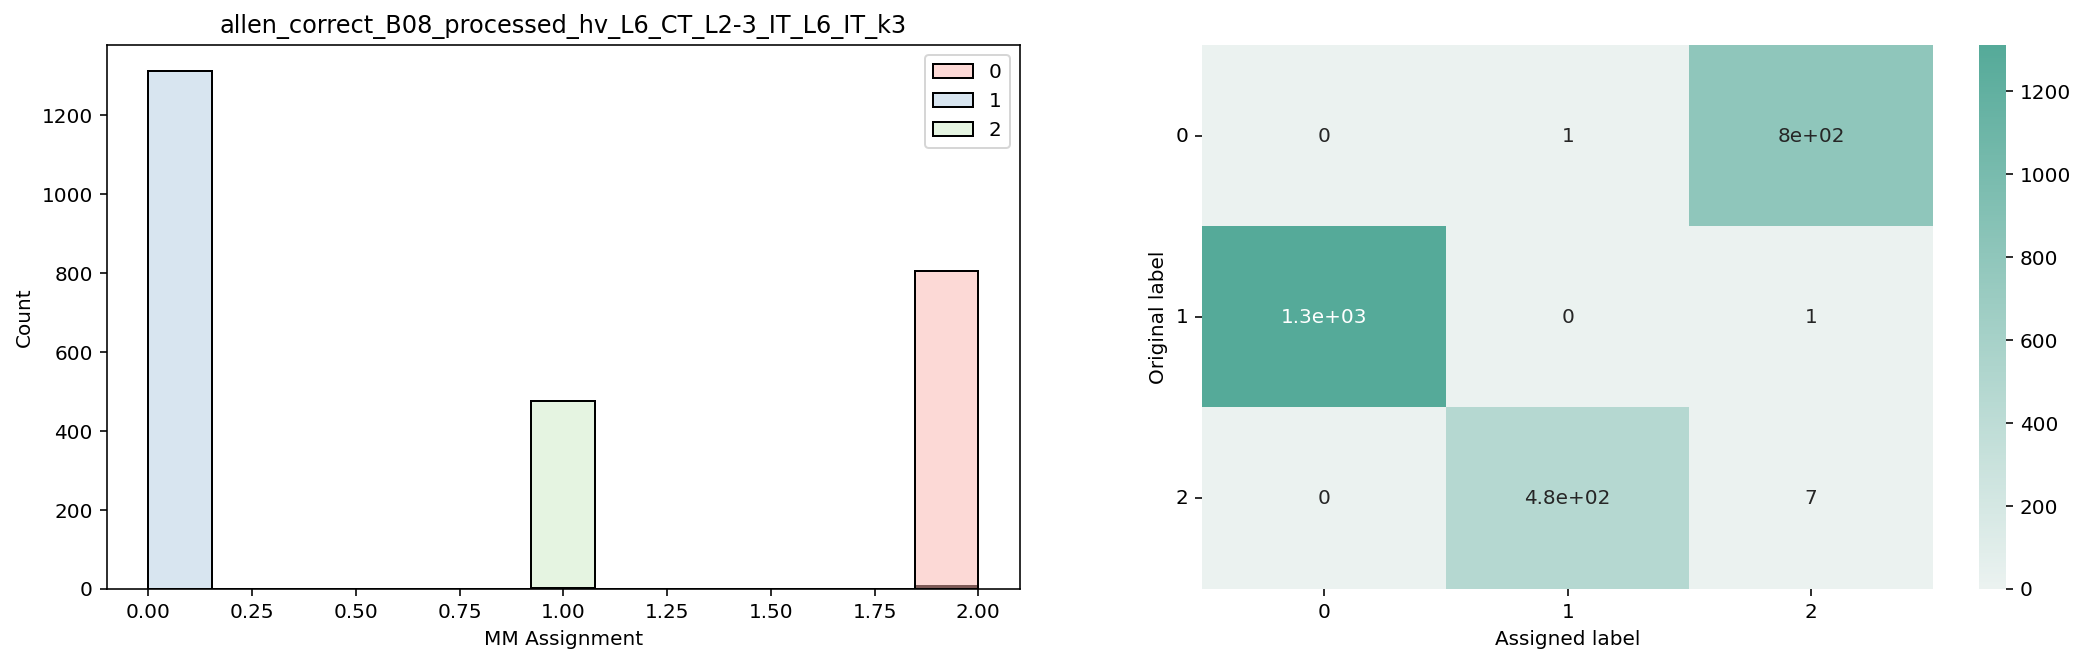

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(5, 5)
(5, 5)


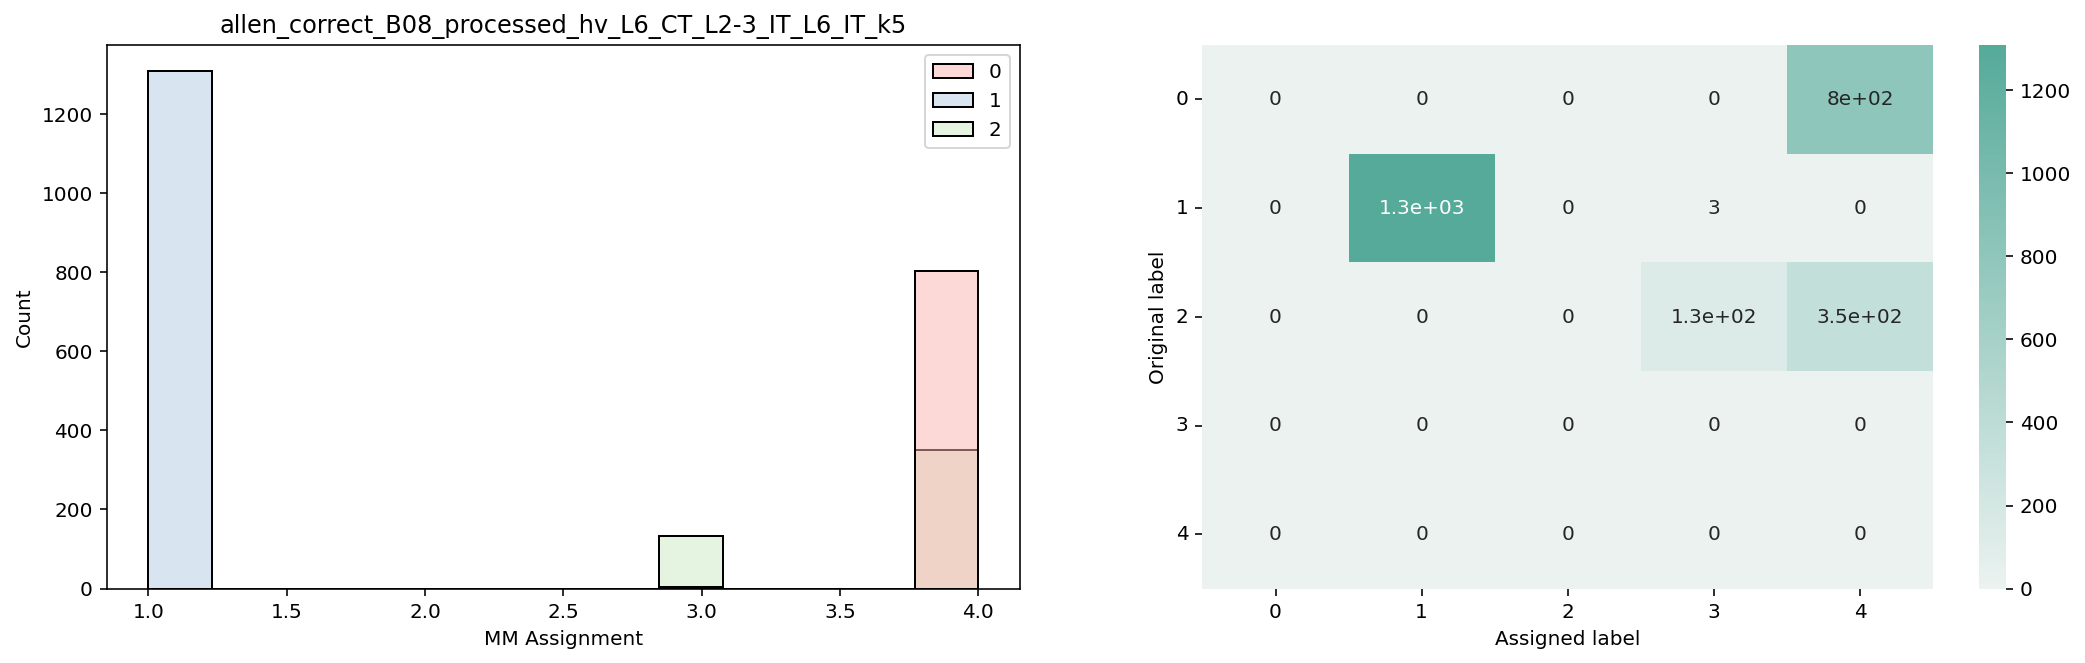

In [152]:
for r in grid_point_results:
    title = r.inference_string.replace('./fits/gg_230413_025_allen_B08_MM_1/','')
    title = title.replace('/Bursty_Poisson_1x1','')
    vis_assign(np.array(all_assigns),r.assigns,title)


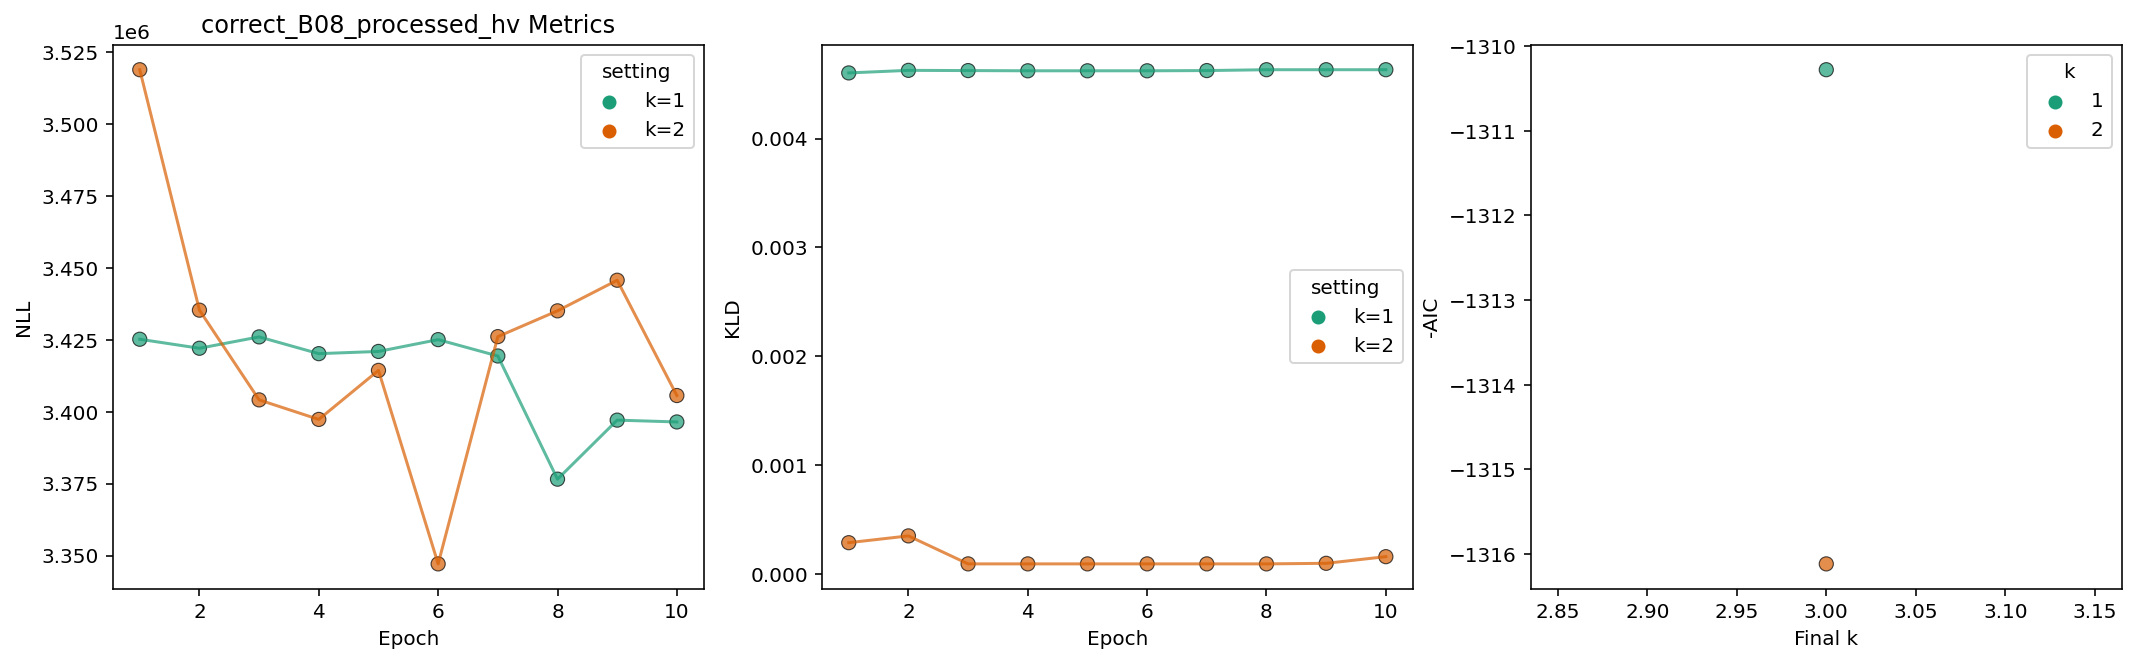

In [153]:
for i in range(0, len(grid_point_results), 5):
    r = grid_point_results[i:i+5]
    title = dataset_meta[i]+' Metrics'
    vis_metrics(r,title)

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(4, 4)


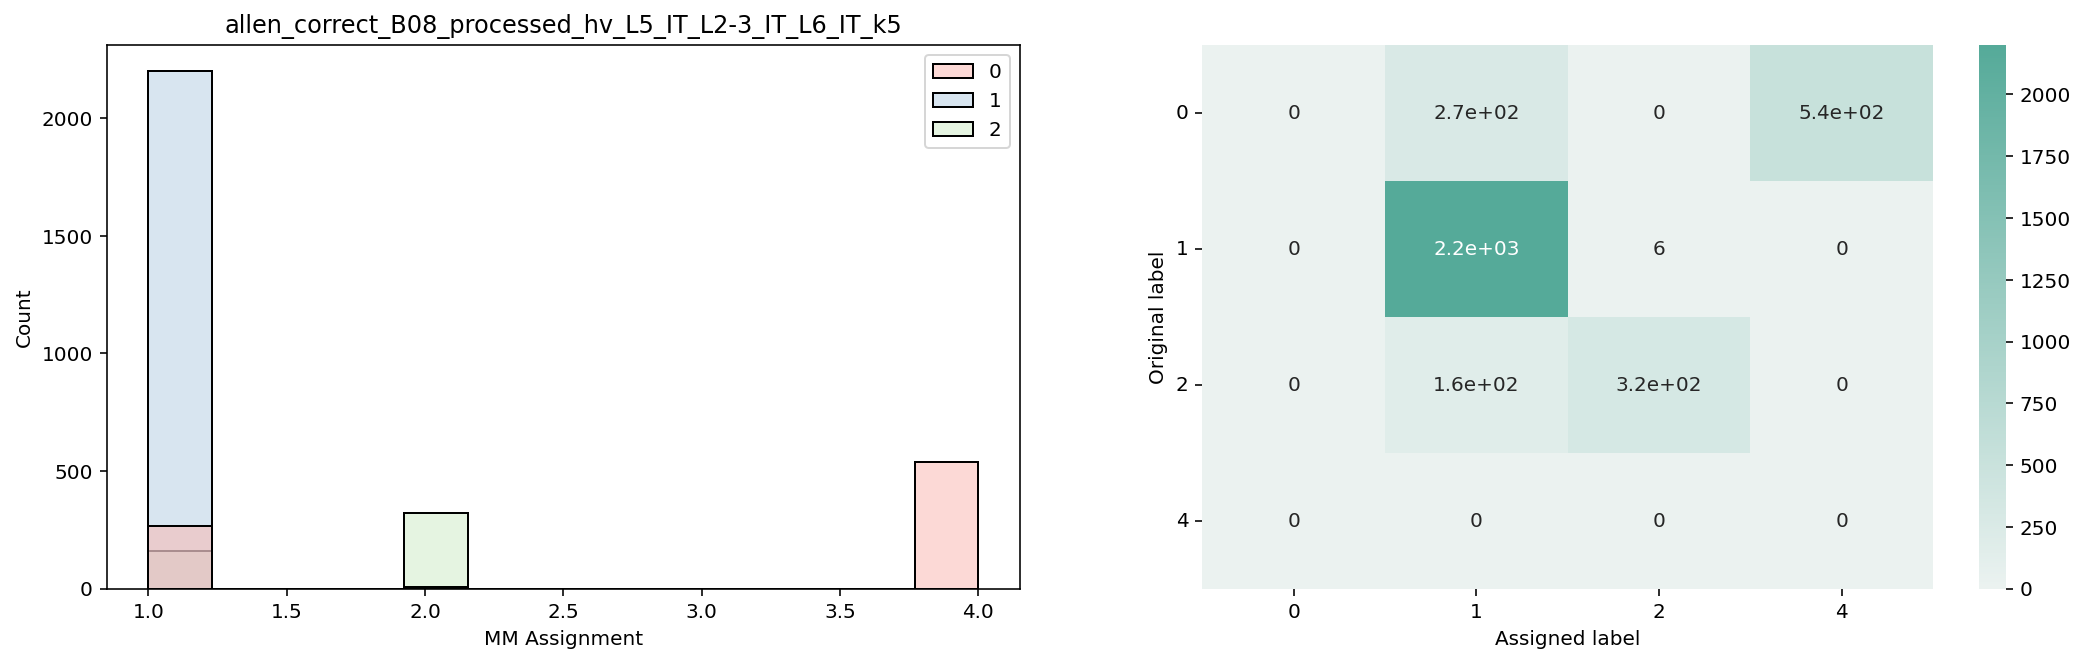

In [128]:
for r in grid_point_results:
    title = r.inference_string.replace('./fits/gg_230413_025_allen_B08_MM_1/','')
    title = title.replace('/Bursty_Poisson_1x1','')
    vis_assign(np.array(all_assigns),r.assigns,title)


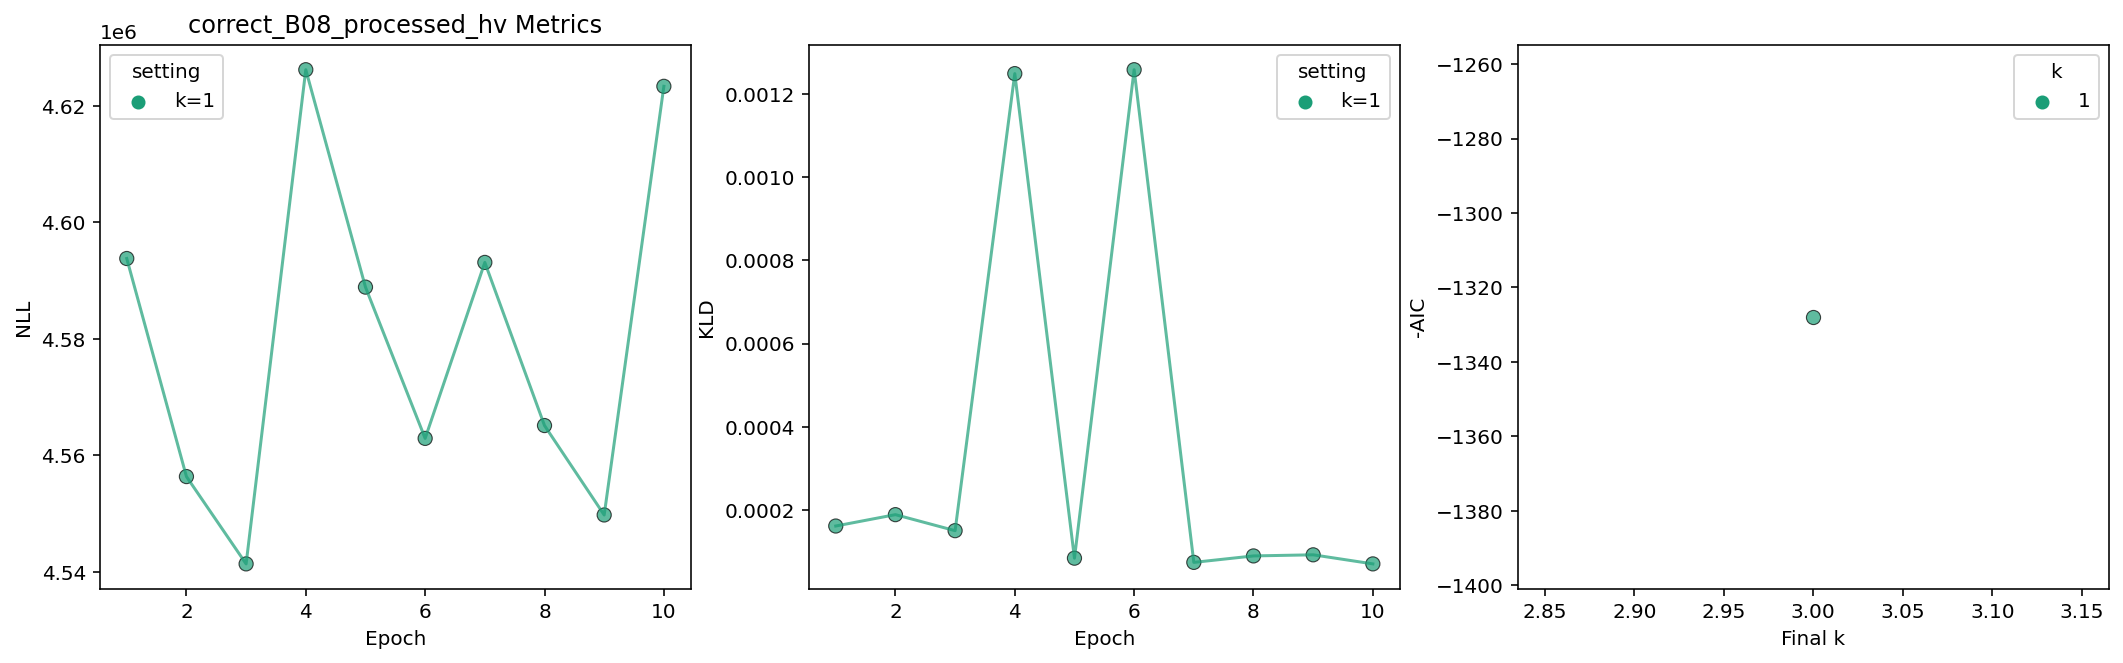

In [130]:
for i in range(0, len(grid_point_results), 5):
    r = grid_point_results[i:i+5]
    title = dataset_meta[i]+' Metrics'
    vis_metrics(r,title)